In [1]:
import timm
import torch 
import torch.nn as nn
from torchvision import models

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import random
from PIL import Image

import os 
from glob import glob
from tqdm import tqdm
from collections import defaultdict
# sns.set_style('darkgrid')

/root/miniconda3/envs/sexy/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = 'cuda'
num_classes = 3
class_name = ['bikini', 'neural','nude']
model = timm.create_model("efficientnet_b1", pretrained=False, num_classes=num_classes, drop_path_rate=0.05)
model.load_state_dict(torch.load('/quyennt/sexy/ckps/student0_efficientnet_b1_ckps_0.962.pt'))
model.to(device)
model.eval()

EfficientNet(
  (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn1): BatchNormAct2d(
    32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
    (drop): Identity()
    (act): SiLU(inplace=True)
  )
  (blocks): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn1): BatchNormAct2d(
          32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): SiLU(inplace=True)
        )
        (se): SqueezeExcite(
          (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
          (act1): SiLU(inplace=True)
          (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
          (gate): Sigmoid()
        )
        (conv_pw): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2): BatchNormAct2d(
      

In [3]:
import torchvision.transforms.functional as F
from torchvision import transforms
class SquarePad:
    def __call__(self, image):
        w, h = image.size
        max_wh = np.max([w, h])
        hp = int((max_wh - w) / 2)
        vp = int((max_wh - h) / 2)
        padding = (hp, vp, hp, vp)
        return F.pad(image, padding, (128,128,128), 'constant')

data_transforms = {
    'train': transforms.Compose([
        SquarePad(),
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        SquarePad(),
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [4]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix',cmap=plt.cm.Blues, export_as="confusion matrix"):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=16)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True labels', fontsize=14)
    plt.xlabel('Predicted labels', fontsize=14)
    
    plt.savefig(f'./result_figs/{export_as}.png', bbox_inches='tight');

In [8]:
predict = []
label = []
s = []
classes = ['bikini', 'neural', 'nude']
for cls in classes:
    for img_path in glob(f"/quyennt/sexy/data/data_1/val/{cls}/*.jpg"):
        img = Image.open(img_path)
        x = data_transforms['val'](img)
        x = x.unsqueeze(0).to(device)
        r = model(x)
        r = r.softmax(dim=-1)
        score , pred = torch.max(r, 1)
        score = score.cpu().detach().numpy()[0]
        pred = pred.cpu().detach().numpy()[0]
        if classes[pred] != cls:
            print(f"pred: {classes[pred]} || GT: {cls}")
            plt.imshow(img)
            plt.show()
#         print(class_name[pred], score)
        
#         if class_name[pred] != 'neural' and score>0.5:
#             predict.append(class_name[pred])
#         else:
#             predict.append('neural')
#         label.append(cls)
#         s.append(score)

In [17]:
from sklearn.metrics import confusion_matrix

In [18]:
matrix = confusion_matrix(label, predict)

In [19]:
matrix

array([[274,  51,   4],
       [ 69, 429,   9],
       [  9,  12,  72]])

Normalized confusion matrix


[]

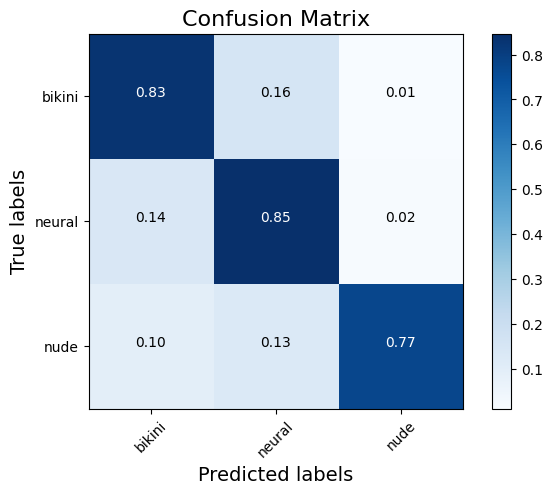

In [20]:
plot_confusion_matrix(matrix, class_name, normalize=True, export_as="coatnet_thres0.5")
plt.plot()